In [1]:
import uproot
import pandas as pd
import awkward as ak
import numpy as np

In [41]:
with uproot.open("../data/gntp.3.gtrac.root") as f:
    # Read all pdg IDs and polarization vectors from all events as two awkward arrays
    pdg = f["gRooTracker;22/StdHepPdg"].array()
    pol = f["gRooTracker;22/StdHepPolz"].array()
    status = f["gRooTracker;22/StdHepStatus"].array()

In [52]:
print(f"{pdg.type}, {pol.type}, {status.type}")
# identify all particles that are tau leptons and extract their polarization vectors and statuses
tau_mask = pdg == 15
tau_pol = ak.flatten(pol[tau_mask])
tau_status = status[tau_mask]
# Check which statuses are present
print(np.unique(ak.flatten(tau_status), return_counts=True))

print(tau_pol.type)

np.sum(np.all(tau_pol == 0, axis=1))

1000000 * var * int32, 1000000 * var * 3 * float64, 1000000 * var * int32
[[1], [422038]]
422038 * 3 * float64


79679

In [47]:
pd.DataFrame(tau_pol.to_numpy(), columns=["polx", "poly", "polz"])

,polx,poly,polz
0,0.086999,0.008235,-0.996174
1,0.000000,0.000000,0.000000
2,0.132538,0.161835,-0.977877
3,0.179302,0.217577,-0.959433
4,-0.229704,0.083774,-0.969648
...,...,...,...
422033,-0.117234,-0.061026,-0.991228
422034,-0.068113,-0.144505,-0.987157
422035,0.131012,0.122818,-0.983744
422036,0.000000,0.000000,0.000000


In [4]:
taus = pd.read_csv("../data/genie_pol_e10.csv")

In [51]:
np.sum(np.all(taus.loc[:, "polx":"polz"] == 0, axis=1))

79679

In [54]:
assert np.all(np.all(tau_pol == 0, axis=1) == (taus.loc[:, "polx":"polz"] == 0).all(axis=1).values)

## Analyze tau lepton energy loss in ice
Based on events simulated with Geant4

In [61]:
g4_taus = pd.read_csv("../data/geant4_tau_output_e50.csv")

In [62]:
assert (g4_taus.groupby("event_num").count() == 2).all().all()

In [63]:
g4_tau_diff = g4_taus.groupby("event_num").diff().dropna(axis=0).drop("status", axis=1)
g4_tau_diff_sig = g4_tau_diff.loc[(g4_tau_diff != 0).any(axis=1), :].copy()
g4_tau_diff_sig["delta_x"] = (g4_tau_diff_sig["x"]**2 + g4_tau_diff_sig["y"]**2 + g4_tau_diff_sig["z"]**2).pow(0.5)

<Axes: xlabel='moved distance (mm)', ylabel='Frequency'>

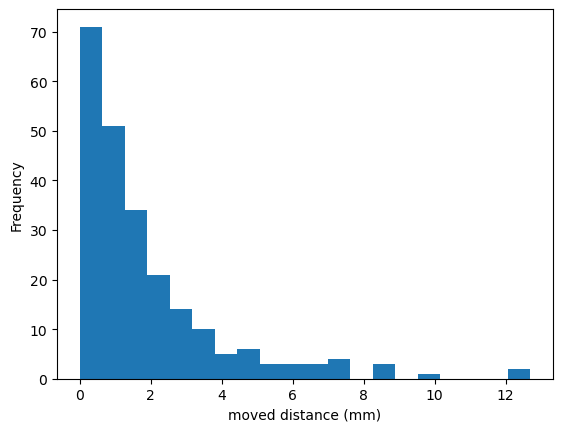

In [64]:
(g4_tau_diff_sig["delta_x"]*1000).plot.hist(bins=20, xlabel="moved distance (mm)")

<Axes: xlabel='energy loss (MeV)', ylabel='Frequency'>

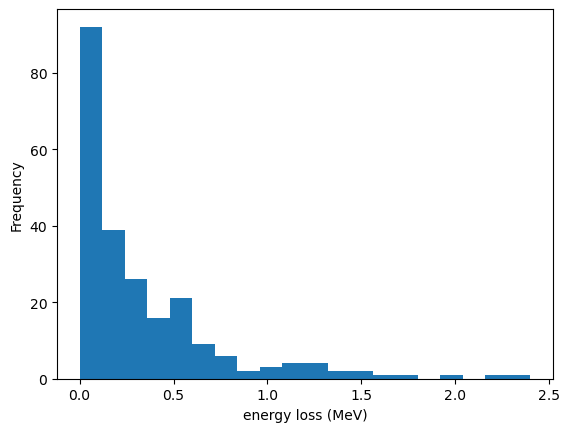

In [65]:
(-g4_tau_diff_sig["E"]*1000).plot.hist(bins=20, xlabel="energy loss (MeV)")

In [66]:
((-g4_tau_diff["E"]*1000) < 1).sum() / len(g4_tau_diff)

0.9971492873218305

## Read all interesting parameters and store to an event file

In [2]:
with uproot.open("../data/gntp.5.gst.root") as f:
    # Read gst/hitnuc
    event_infos = f["gst"].arrays(["iev", "qel", "res", "dis", "cc", "sea", "hitqrk", "xs", "ys", "Q2s", "Ws", "hitnuc", "A", "resid", "En", "pxn", "pyn", "pzn", "charm", "Ev", "pxv", "pyv", "pzv"])


In [3]:
ev = event_infos[event_infos["iev"] < 50000]
ev["Mnuc"] = np.sqrt(ev["En"]**2 - ev["pxn"]**2 - ev["pyn"]**2 - ev["pzn"]**2)
ev["event_num"] = ev["iev"]
ev["qel"] = ev["qel"] & ev["cc"]
ev["res"] = ev["res"] & ev["cc"]
ev["dis"] = ev["dis"] & ev["cc"]
ev["atom"] = ev["A"]
ev["Enu"] = ev["Ev"]
ev["pxnu"] = ev["pxv"]
ev["pynu"] = ev["pyv"]
ev["pznu"] = ev["pzv"]

In [4]:
# Convert awkward array to pandas
ev_df = pd.DataFrame(ev.to_numpy(), columns=ev.fields)
ev_df.to_csv("../data/genie_tau_pol_data_gst.csv", index=False)

## Compare gst file values to manual extraction

In [36]:
# Using my own code
# gst = pd.read_csv("../data/genie_tau_pol_data_gst_f.csv")
# Using GENIE's DIS calculation, where I have created an Interaction object from the gst info
gst_int = pd.read_csv("../data/genie_tau_pol_data_gst_res_dis.csv")
# Using the Interaction object inside the GHEP file (correct values)
manual = pd.read_csv("../data/genie_tau_pol_data_e100_1.csv")

In [37]:
non_float_cols = ["qel", "res", "dis", "sea", "charm", "hitqrk", "event_num", "atom", "hitnuc"]
# assert (gst.loc[gst["dis"] | gst["res"] | gst["qel"], non_float_cols] == manual.loc[manual["dis"] | manual["res"] | manual["qel"], non_float_cols]).all().all()
assert (gst_int.loc[gst_int["dis"] | gst_int["res"] | gst_int["qel"], non_float_cols] == manual.loc[manual["dis"] | manual["res"] | manual["qel"], non_float_cols]).all().all()

In [38]:
float_cols = ["Mnuc", "xs", "Q2s"]
close_vals = np.isclose(gst_int.loc[gst_int["res"], float_cols], manual.loc[manual["res"], float_cols], atol=1e-6)
assert close_vals.all().all()
close_vals = np.isclose(gst_int.loc[gst_int["res"], float_cols], manual.loc[manual["res"], float_cols], atol=1e-6)
assert close_vals.all().all()

The extraction method seems to be correct, and all values match

In [39]:
f_close = np.isclose(gst_int.loc[gst_int["sigmm"].notnull(), ["sigmm","sigpp"]], manual.loc[manual["sigmm"].notnull(), ["sigmm","sigpp"]], atol=1e-4).all(axis=1)

In [40]:
gst_int.loc[gst_int["sigmm"].notnull(), ["sigmm","sigpp"]]

,sigmm,sigpp
23,0.580899,0.000205
90,0.066351,0.000032
229,0.008338,0.000004
245,0.232408,0.000126
262,0.058504,0.000042
...,...,...
49728,2.760720,0.001144
49747,0.123471,0.000076
49779,0.528816,0.000288
49824,0.440913,0.000135


In [42]:
manual.loc[manual["sigmm"].notnull(), ["sigmm","sigpp"]]

,sigmm,sigpp
23,0.580899,0.000205
90,0.066351,0.000032
229,0.008338,0.000004
245,0.232408,0.000126
262,0.058504,0.000042
...,...,...
49728,2.760719,0.001144
49747,0.123471,0.000076
49779,0.528816,0.000288
49824,0.440913,0.000135


In [44]:
f_close.all()

True